# Oversampling on class + more Grid search

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import warnings

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import loguniform
from sklearn.pipeline import make_pipeline
from pickle import dump

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

# set this to False to avoid GridSearchCV
debug = False

Importing datasets manually

In [ ]:
df_red = pd.read_csv('../winequality-red.csv', sep=';')
df_white = pd.read_csv('../winequality-white.csv', sep=';')

I add a color column to the datasets

In [ ]:
df_red['color'] = 0    # per red
df_white['color'] = 1  # per white
df_red

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,0
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,0
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,0
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,0
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,0
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,0
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,0


i'm applying oversampling to the red dataset so it does not have a lot less values than white

In [4]:

X_red = df_red.drop(columns='quality')
y_red = df_red['quality']

smote = SMOTE(random_state=42)
X_red_resampled, y_red_resampled = smote.fit_resample(X_red, y_red)

I concatenate the red and white datasets to have a single one

In [5]:
red_wine_resampled = pd.concat([
    pd.DataFrame(X_red_resampled, columns=X_red.columns),
    pd.Series(y_red_resampled, name='quality')
], axis=1)

data = pd.concat([red_wine_resampled, df_white], ignore_index=True)

data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,color,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,0,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,0,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,0,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8979,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,1,6
8980,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,1,5
8981,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,1,6
8982,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,1,7


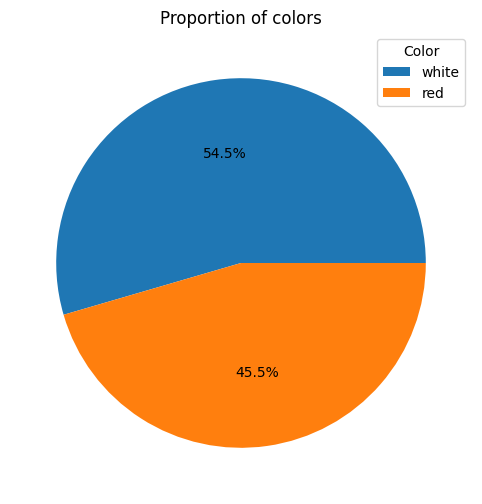

In [45]:
colors = data['color'].map({0: 'red', 1: 'white'})
count = colors.value_counts()
plt.figure(figsize=(10, 6))
plt.pie(count, labels=None, autopct='%1.1f%%')
plt.title('Proportion of colors')
plt.legend(labels=count.index, title="Color", loc="best")
plt.show()

Now the dataset is pretty balanced among the two classes of colors

## Regrouping the target classes

3--4 $\rightarrow$ 1;   
5 $\rightarrow$ 2;  
6 $\rightarrow$ 3;  
7--8--9 $\rightarrow$ 4;    



In [6]:
data['quality'] = data['quality'].replace({
    3: 1, 4: 1,
    5: 2,
    6: 3,
    7: 4, 8: 4, 9: 4
})


In [7]:
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,color,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0,2
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,0,2
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,0,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,0,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8979,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,1,3
8980,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,1,2
8981,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,1,3
8982,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,1,4


## Expolaratory Data analysis

We start with a pie chart to look at the proportion of quality levels

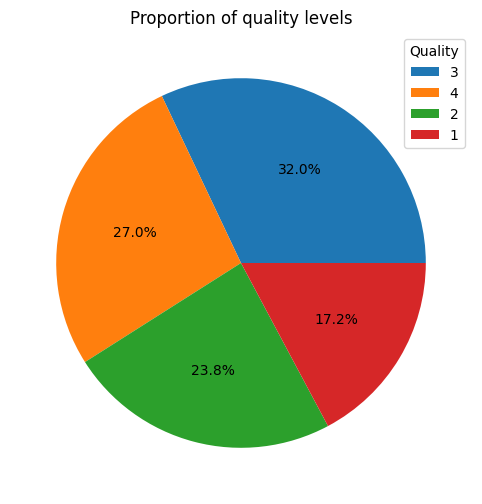

In [8]:
y = data['quality']
count = y.value_counts()
plt.figure(figsize=(10, 6))
plt.pie(count, labels=None, autopct='%1.1f%%')
plt.title('Proportion of quality levels')
plt.legend(labels=count.index, title="Quality", loc="best")
plt.show()

The distribution looks acceptable, but I will try applying oversampling to balance the number of occurrences across the different quality categories.

### SMOTE

In [ ]:
X = data.drop(columns='quality')
X_resampled, y_resampled = SMOTE().fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2)
X_train

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,color
5526,7.200000,0.260000,0.740000,13.600000,0.050000,56.000000,162.000000,0.998000,3.030000,0.440000,8.800000,1
8499,5.800000,0.300000,0.380000,4.900000,0.039000,22.000000,86.000000,0.989630,3.230000,0.580000,13.100000,1
5489,7.100000,0.260000,0.310000,2.200000,0.044000,29.000000,128.000000,0.993700,3.340000,0.640000,10.900000,1
9500,7.043514,0.811802,0.017756,4.145207,0.095812,4.782817,13.007224,0.996843,3.432154,0.575502,11.054296,0
9405,7.117160,0.702654,0.069611,3.514877,0.072757,14.546914,28.320371,0.995820,3.400938,0.506407,10.760186,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11284,6.547249,0.257385,0.284725,1.142201,0.064624,38.894498,124.000000,0.991231,3.334725,0.563120,11.147703,1
5191,5.500000,0.320000,0.450000,4.900000,0.028000,25.000000,191.000000,0.992200,3.510000,0.490000,11.500000,1
5390,8.000000,0.590000,0.710000,17.350000,0.038000,61.000000,228.000000,1.000000,2.950000,0.750000,9.300000,1
860,7.200000,0.620000,0.060000,2.700000,0.077000,15.000000,85.000000,0.997460,3.510000,0.540000,9.500000,0


We can see that the number of observations is now balanced across all classes, indicating that the data has been successfully rescaled using SMOTE.

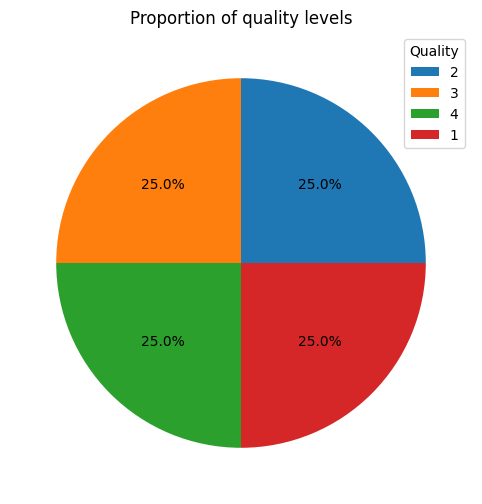

In [10]:
count = y_resampled.value_counts()
plt.figure(figsize=(10, 6))
plt.pie(count, labels=None, autopct='%1.1f%%')
plt.title('Proportion of quality levels')
plt.legend(labels=count.index, title="Quality", loc="best")
plt.show()

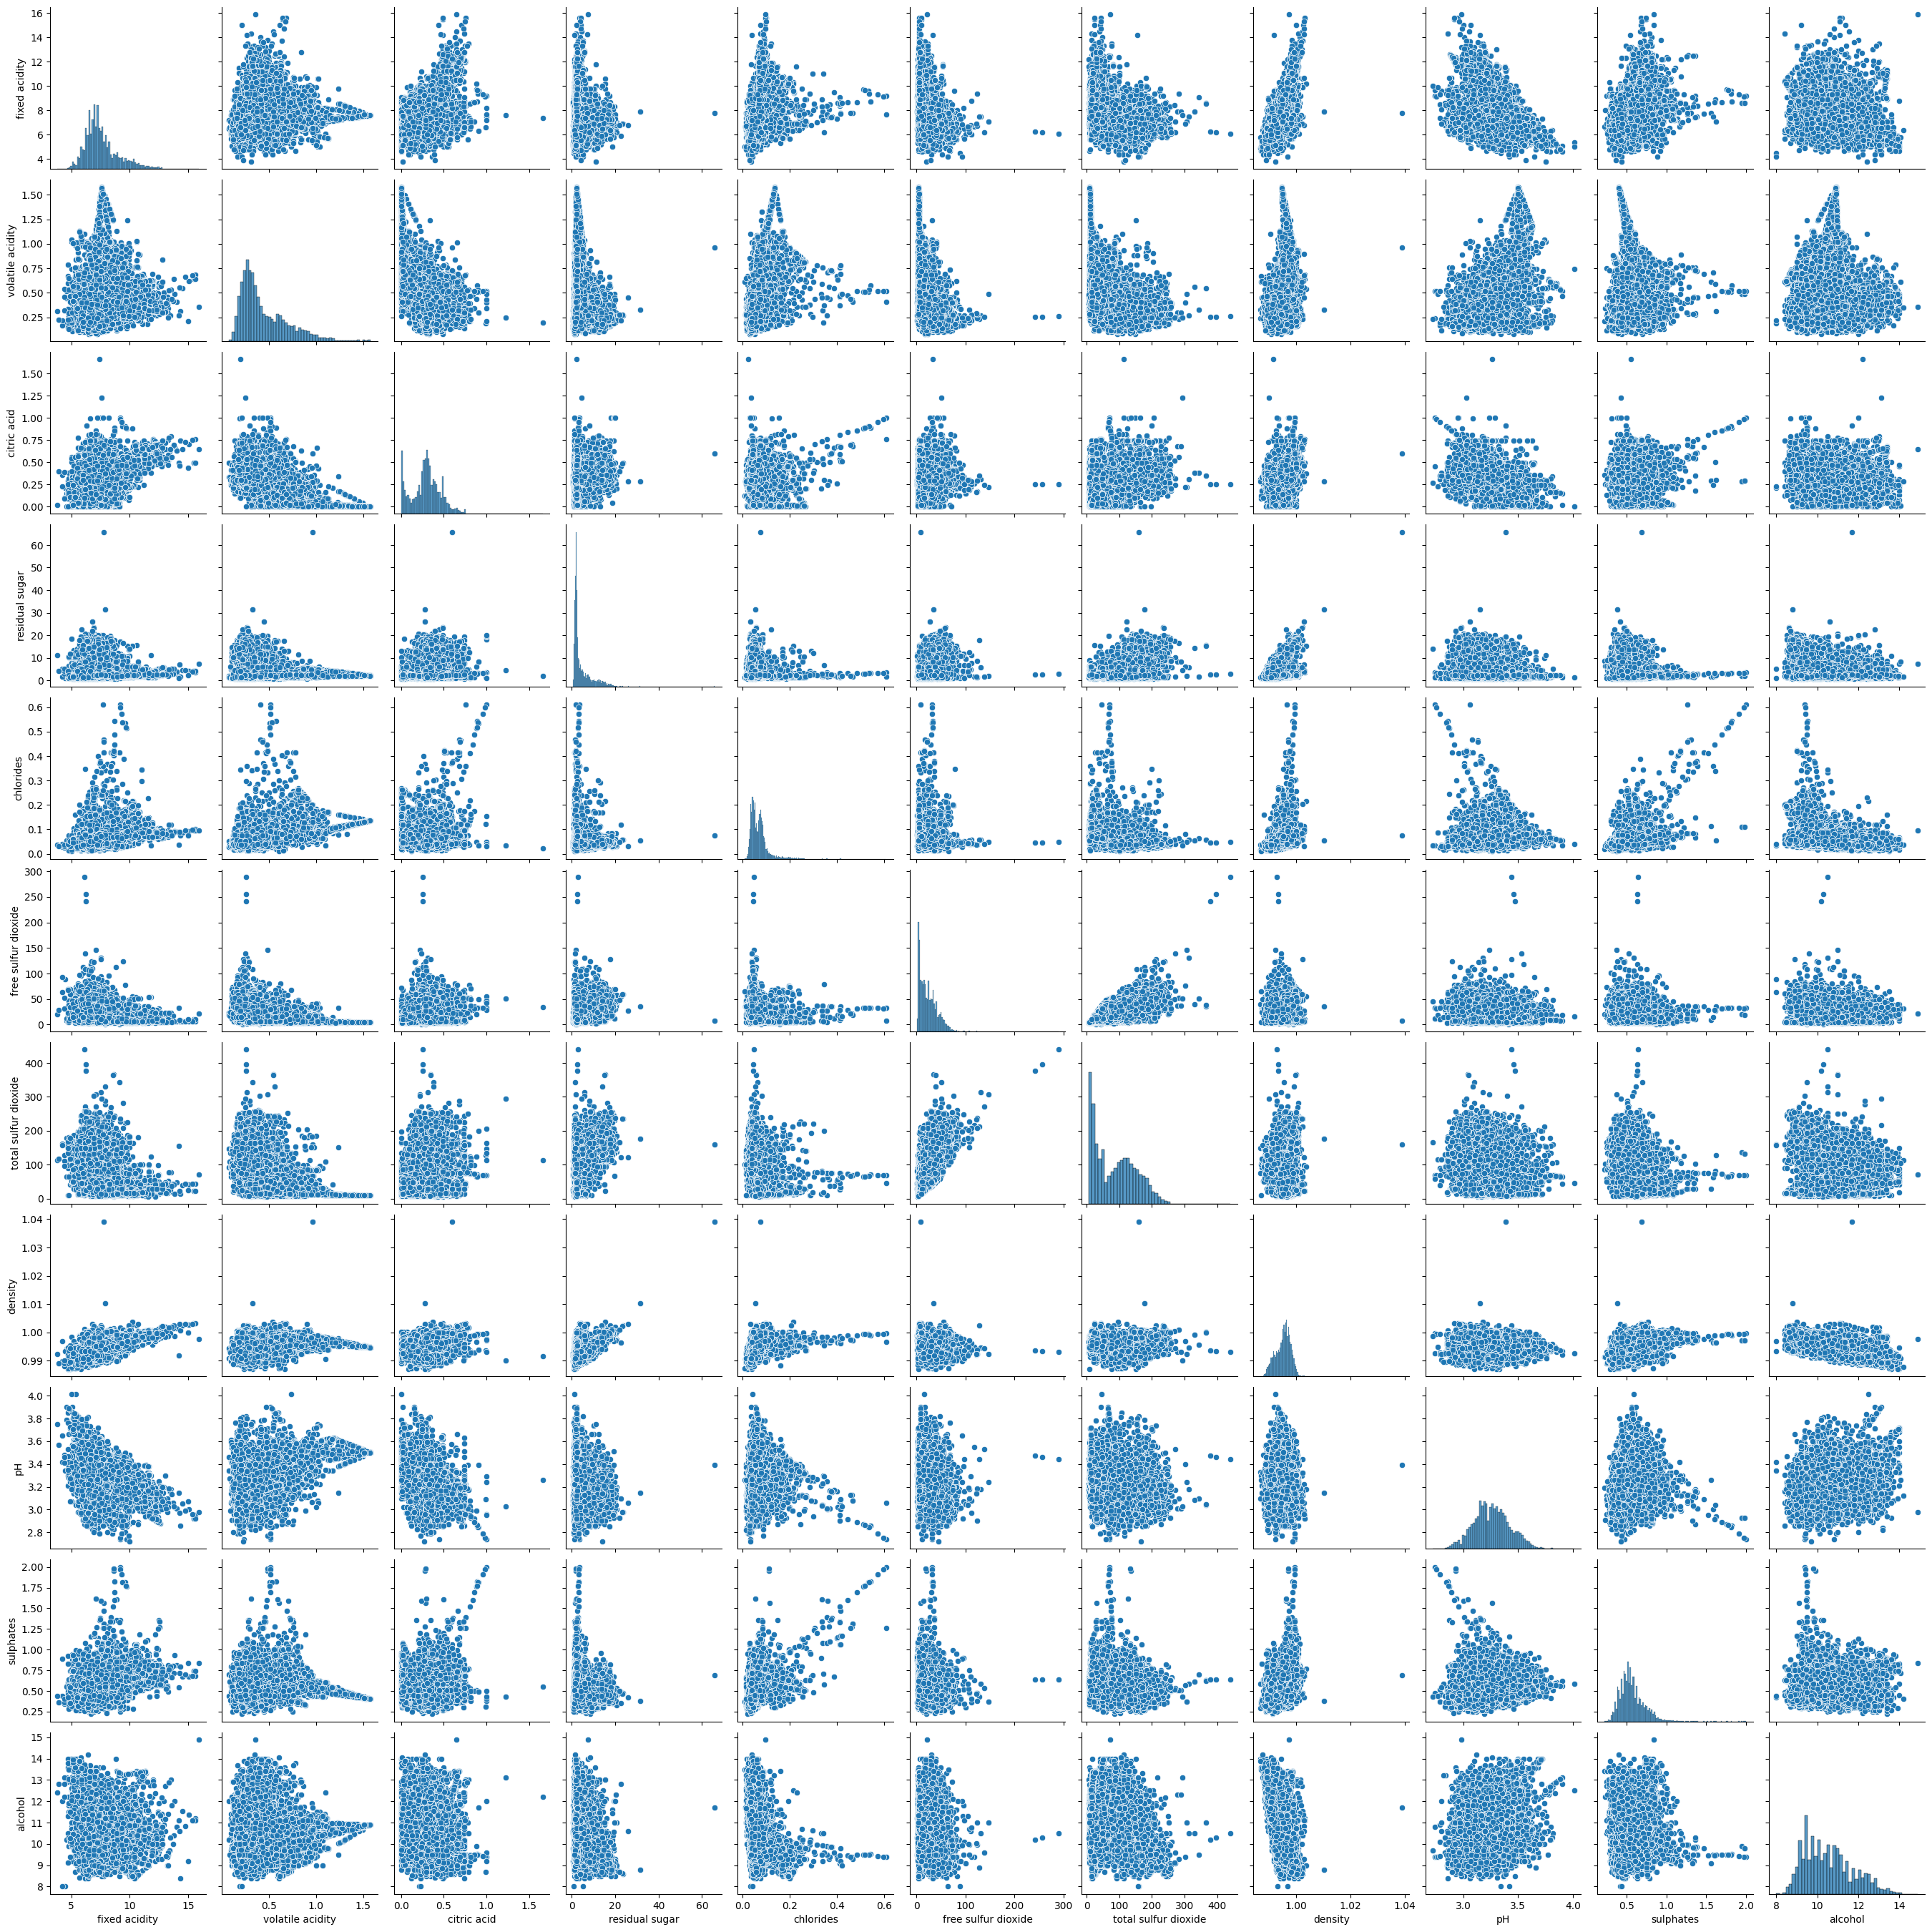

In [11]:
sns.pairplot(X_resampled.drop(columns='color'))

In the pairplot, is not visible any clear correlation among the features, also the distribution, are, in large case, unknown. This is due the fact that we melted the two datasets together, leading to a reshuffling of the distribution of each features.

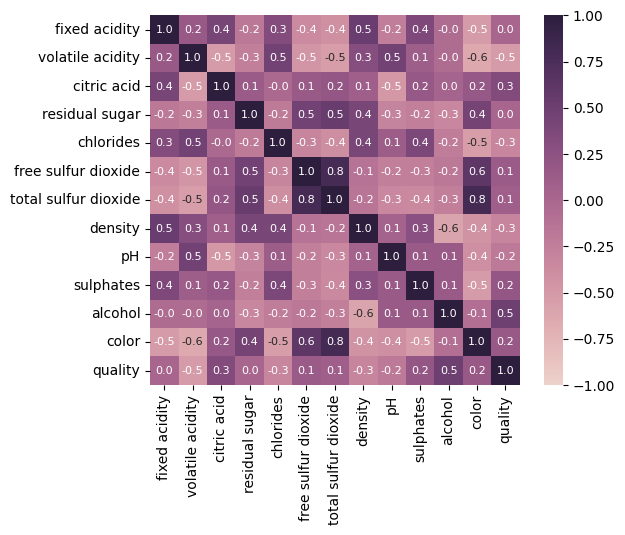

In [69]:
correlation = data.corr()

axis_corr = sns.heatmap(
    correlation,
    vmin=-1, vmax=1, center=0,
    cmap=sns.cubehelix_palette(as_cmap=True),
    square=True,
    annot=True,
    fmt=".1f",
    annot_kws={"size": 8}
)

plt.show()

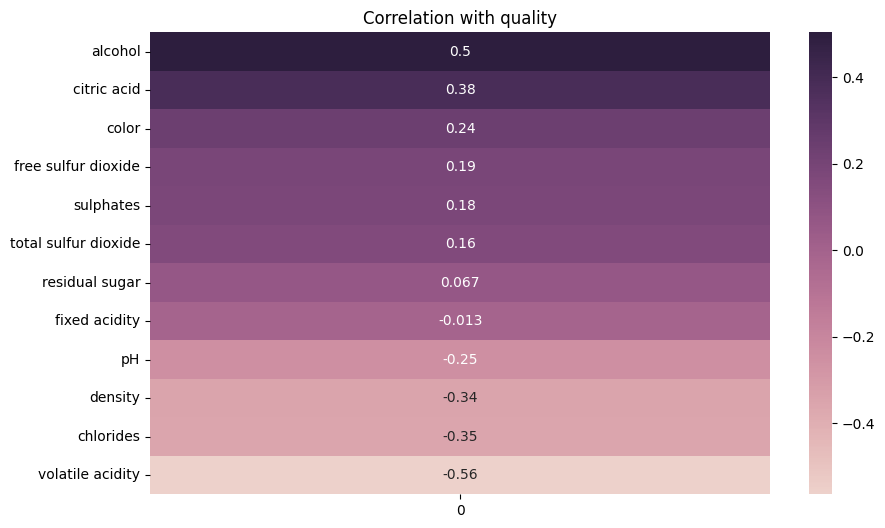

In [71]:
corr = X_resampled.corrwith(y_resampled)

corr_sorted = corr.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.heatmap(
    corr_sorted.to_frame(),
    annot=True,
    cmap=sns.cubehelix_palette(as_cmap=True),
)
plt.title('Correlation with quality')
plt.show()

## Feature Engineering and Selection

#### Correlation matrix and collinearity with `quality` feature

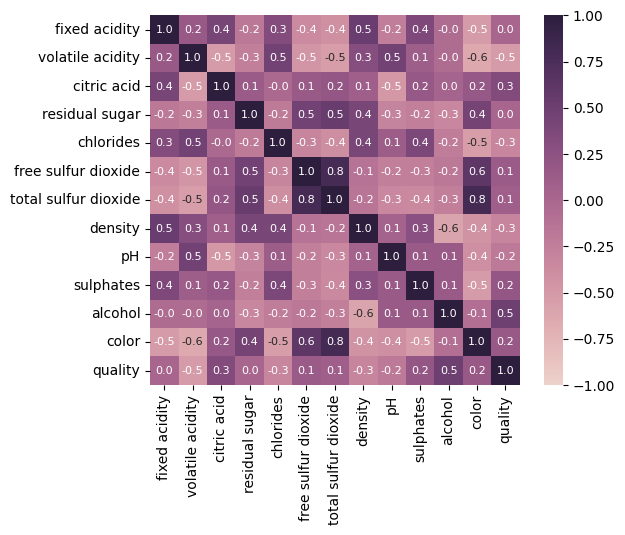

In [54]:
data_engineered = data.copy()

correlation = data_engineered.corr()

axis_corr = sns.heatmap(
    correlation,
    vmin=-1, vmax=1, center=0,
    cmap=sns.cubehelix_palette(as_cmap=True),
    square=True,
    annot=True,
    fmt=".1f",
    annot_kws={"size": 8}
)

plt.show()

As we can see from the correlation matrix, there are some features that are highly correlated with each other. This can lead to collinearity issues in our model, so we will need to be careful about which features we include in our final model. For instance `total sulfur dioxide` and `free sulfur dioxide` have 0.8 correlation coefficient, so we will drop them in favor of a new feature that rapresents the difference called `bound sulfur dioxide`

In [55]:
data_engineered['bound sulfur dioxide'] = data_engineered['total sulfur dioxide'] - data_engineered['free sulfur dioxide']
data_engineered.drop(columns=['total sulfur dioxide', 'free sulfur dioxide'], inplace=True)
data_engineered

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,density,pH,sulphates,alcohol,color,quality,bound sulfur dioxide
0,7.4,0.70,0.00,1.9,0.076,0.99780,3.51,0.56,9.4,0,2,23.0
1,7.8,0.88,0.00,2.6,0.098,0.99680,3.20,0.68,9.8,0,2,42.0
2,7.8,0.76,0.04,2.3,0.092,0.99700,3.26,0.65,9.8,0,2,39.0
3,11.2,0.28,0.56,1.9,0.075,0.99800,3.16,0.58,9.8,0,3,43.0
4,7.4,0.70,0.00,1.9,0.076,0.99780,3.51,0.56,9.4,0,2,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8979,6.2,0.21,0.29,1.6,0.039,0.99114,3.27,0.50,11.2,1,3,68.0
8980,6.6,0.32,0.36,8.0,0.047,0.99490,3.15,0.46,9.6,1,2,111.0
8981,6.5,0.24,0.19,1.2,0.041,0.99254,2.99,0.46,9.4,1,3,81.0
8982,5.5,0.29,0.30,1.1,0.022,0.98869,3.34,0.38,12.8,1,4,90.0


Moreover, `free sulfur dioxide` and `color` have a correlation coefficient of 0.6, but we believe that most of the values of the feature have that value because of the type of the wine (red and white). So, we choose not to drop these features.

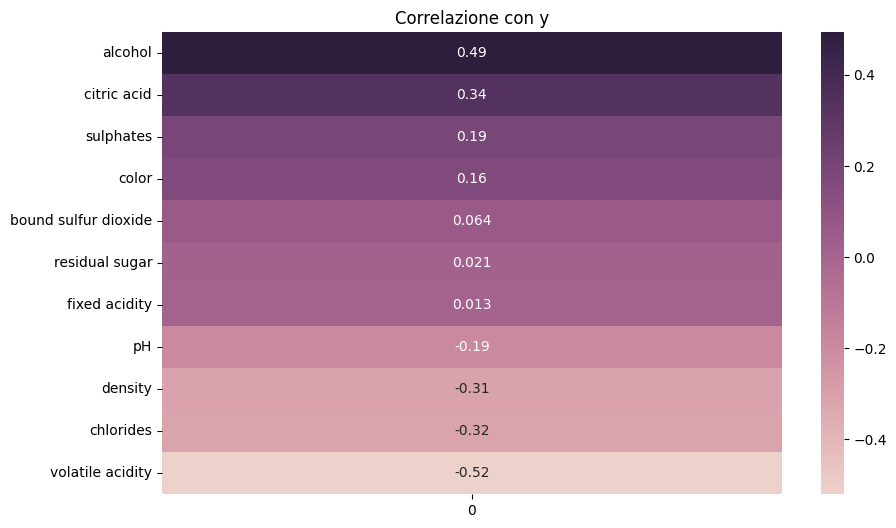

In [56]:
X_engineered = data_engineered.drop(columns=['quality'])
y_engineered = data_engineered['quality']

corr = X_engineered.corrwith(y_engineered)

corr_sorted = corr.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.heatmap(
    corr_sorted.to_frame(),
    annot=True,
    cmap=sns.cubehelix_palette(as_cmap=True),
)
plt.title('Correlazione con y')
plt.show()

Finally, we whould like to drop the features that are under 0.2 for their correlation with the `quality` feature but we have too few observations, so we will keep all the features. Another thing to take into account is that the new added feature `bound sulfur dioxide` seems not to add information  to the overall scenario, so we can think to not do feature engineering to the dataset.

In [68]:
X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(X_engineered, y_engineered, test_size=0.2, random_state=42)

def evaluate_model(models, X_train, y_train, X_test, y_test):
    for model in models:
        acc_sum = 0
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc_sum += accuracy_score(y_test, y_pred)
    return acc_sum / len(models)

# Evaluate different models
models_for_evaluation = {
    DecisionTreeClassifier(random_state=42),
    MLPClassifier(random_state=42, max_iter=500)
}

accuracy_eng = evaluate_model(models_for_evaluation, X_train_eng, y_train_eng, X_test_eng, y_test_eng)
accuracy_noeng = evaluate_model(models_for_evaluation, X_train, y_train, X_test, y_test)

print(f"Accuracy with engineering: {accuracy_eng:.2f}")
print(f"Accuracy without engineering: {accuracy_noeng:.2f}")


Accuracy with engineering: 0.35
Accuracy without engineering: 0.38


The avarage accuracy seems to be a worst in the engineered case, so what we have done until now is not useful. We will keep the original dataset and try to improve the model with a better hyperparameter tuning.

## Principal Component Analysis(PCA)

In [72]:
X_scaled = X_resampled.copy()

cols_to_scale = X_scaled.columns.difference(['color'])

scaler = StandardScaler()
X_scaled[cols_to_scale] = scaler.fit_transform(X_scaled[cols_to_scale])

In [73]:
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

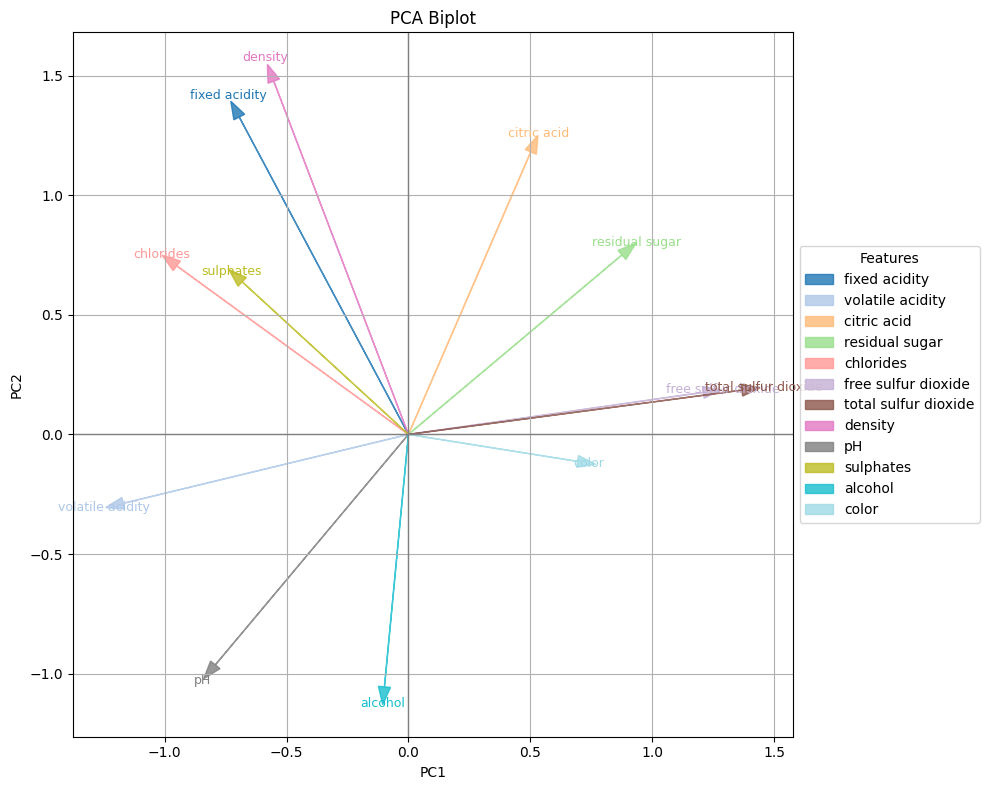

In [ ]:
loadings = pca.components_.T 
feature_names = X_scaled.columns

cmap = cm.get_cmap('tab20', len(feature_names))  
plt.figure(figsize=(10, 8))

for i, feature in enumerate(feature_names):
    plt.arrow(0, 0,
              loadings[i, 0] * 3,
              loadings[i, 1] * 3,
              color=cmap(i), alpha=0.8, head_width=0.05, label=feature)
    plt.text(loadings[i, 0] * 3.2,
             loadings[i, 1] * 3.2,
             feature, color=cmap(i), ha='center', va='center', fontsize=9)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Features")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Biplot")

plt.grid(True)
plt.axhline(0, color='gray', lw=1)
plt.axvline(0, color='gray', lw=1)
plt.tight_layout()
plt.show()

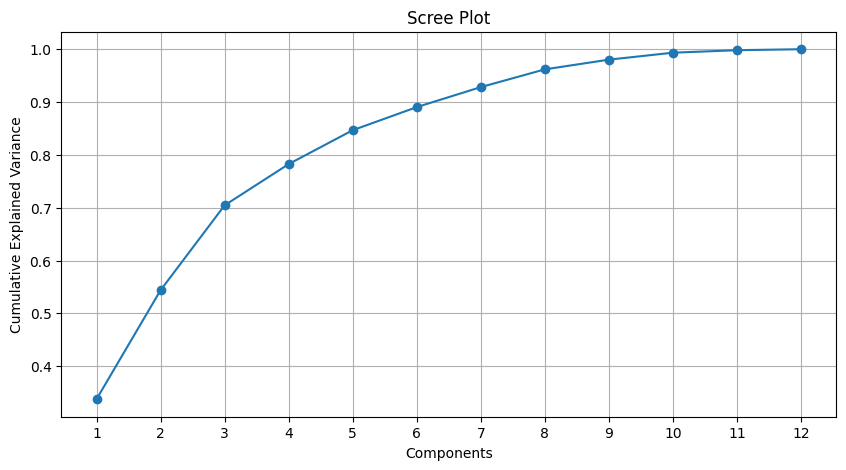

In [89]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(pca_full.explained_variance_ratio_) + 1), np.cumsum(pca_full.explained_variance_ratio_), marker='o')
plt.xlabel('Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.grid(True)
plt.xticks(np.arange(1, len(pca_full.explained_variance_ratio_) + 1, 1))
plt.show()

Let's check how much variance each principal component explains. We can see that the first four components explain around 80% of the amount of variance, which suggests that PCA could be useful for dimensionality reduction in this dataset. Anyway, we made similar considerations in the previous section, showing that reducing the number of feature leads to a worse model, so we will not use PCA in this case.

In [103]:
pve = pca_full.explained_variance_ratio_
for i, v in enumerate(pve):
    print(f"PC{i+1}: {v:.4f}")

print("\nFirst four components cumulative explained variance:\n",
      pca_full.explained_variance_ratio_[0:4].sum())

PC1: 0.3374
PC2: 0.2063
PC3: 0.1607
PC4: 0.0781
PC5: 0.0641
PC6: 0.0437
PC7: 0.0379
PC8: 0.0336
PC9: 0.0184
PC10: 0.0132
PC11: 0.0047
PC12: 0.0019

First four components cumulative explained variance:
 0.7825536298532245


# Experiments
We start by looking at the best performing models w/o optmization.
First we load the models

In [106]:
models = {
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'MLP': MLPClassifier(max_iter=2000),
    'Decision Tree': DecisionTreeClassifier()
}

We then scale the datasets

In [107]:
cols_to_scale = X.columns.difference(['color'])

scaler = StandardScaler()
scaler.fit(X_train[cols_to_scale])

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[cols_to_scale] = scaler.transform(X_train[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

And now we train all the models to select the best performing ones.

In [108]:
best_model = None
best_accuracy = 0
results = {}
best_models ={}

for name, model in models.items():

    # We don't need the scaled data for Decision Tree
    if name == 'Decision Tree':
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")

    # If the model has an accuracy >= 0.7, we save it
    if acc >= 0.7:
        best_models[name] = model


    if acc > best_accuracy:
        best_accuracy = acc
        best_model = name

print(f"best model: {best_model} with accuracy {best_accuracy:.4f}")

SVM Accuracy: 0.7014
Logistic Regression Accuracy: 0.6476
MLP Accuracy: 0.7140
Decision Tree Accuracy: 0.7582
best model: Decision Tree with accuracy 0.7582


In [109]:
best_models

{'SVM': SVC(),
 'MLP': MLPClassifier(max_iter=2000),
 'Decision Tree': DecisionTreeClassifier()}

We define a few hyperparameters to tune for each model. We will use GridSearchCV to find the best hyperparameters for each model. 

In [110]:
param_grids = {
    'MLP': {
        'hidden_layer_sizes': [(50,), (100,), (100, 50)],
        'alpha': [0.0001, 0.001]
    },
    'Decision Tree': {
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 5, 10]
    },
    'SVM': {
        'C': [0.1, 1, 10]
    },
    'Logistic Regression': {
        'C': [0.1, 1, 10]
    }
}

# FIltering to tune only the models that have been saved into best_models
param_grids = {k: v for k, v in param_grids.items() if k in best_models}
param_grids

{'MLP': {'hidden_layer_sizes': [(50,), (100,), (100, 50)],
  'alpha': [0.0001, 0.001]},
 'Decision Tree': {'max_depth': [5, 10, None],
  'min_samples_split': [2, 5, 10]},
 'SVM': {'C': [0.1, 1, 10]}}

In [111]:
if debug:
    for name, model in best_models.items():
        if name != 'Decision Tree':
            x_train = X_train_scaled
        else:
            x_train = X_train

        grid = GridSearchCV(estimator=model, param_grid=param_grids[name], cv=5, scoring='accuracy', n_jobs=1)

        grid.fit(x_train, y_train)

        print("Model: ", name)
        print("Best Score: ", grid.best_score_)
        print("Best Params: ", grid.best_params_)
        print()

Model:  SVM
Best Score:  0.7231877167649639
Best Params:  {'C': 10}

Model:  MLP
Best Score:  0.7561875406135138
Best Params:  {'alpha': 0.0001, 'hidden_layer_sizes': (100, 50)}

Model:  Decision Tree
Best Score:  0.7219935984559942
Best Params:  {'max_depth': None, 'min_samples_split': 2}



We obtained strong results across all models, and the MLP seems to have the best performance with 0.75 of grid search score. Next, we'll look at the test set accuracy to assess whether the model is overfitting.

In [ ]:
if debug:
    model_mlp = MLPClassifier(
        hidden_layer_sizes=(100,50),
        alpha = 0.0001,
    )

    model_mlp.fit(X_train_scaled, y_train)

    y_pred_test = model_mlp.predict(X_test_scaled)

    print("\nTesting")
    print(classification_report(y_test, y_pred_test))


Testing
              precision    recall  f1-score   support

           1       0.94      0.89      0.91       583
           2       0.63      0.71      0.67       565
           3       0.57      0.55      0.56       586
           4       0.80      0.76      0.78       570

    accuracy                           0.73      2304
   macro avg       0.73      0.73      0.73      2304
weighted avg       0.74      0.73      0.73      2304



The difference between training and testing accuracy is small, which suggests that the model is reliable.

In conclusion, the best model found using SMOTE oversampling is a Multi-Layer Perceptron Classifier with two hidden layers (the first with 100 neurons and the second with 50) and alpha value of 0.0001

It achieved a testing accuracy of 73%.

## Wider Parameter-space Grid search 

We are trying to optimize the MLPClassifier with a wider parameter space.
The parameters are:
- `hidden_layer_sizes`: [ (128,), (128, 64), (128, 64, 32)]

- `activation`: ['relu', 'tanh']

- `solver`: ['adam', 'sgd'] 

- `alpha`: loguniform(1e-5, 1e-1) 

- `learning_rate`: ['constant', 'adaptive'] 

- `learning_rate_init`: loguniform(1e-4, 1e-1) 

In [ ]:
if debug:
    pipeline = make_pipeline(StandardScaler(), MLPClassifier(max_iter=500, random_state=42))

    param_dist = {
        'mlpclassifier__hidden_layer_sizes': [ (128,), (128, 64), (128, 64, 32)],
        'mlpclassifier__activation': ['relu', 'tanh'],
        'mlpclassifier__solver': ['adam', 'sgd'],
        'mlpclassifier__alpha': loguniform(1e-5, 1e-1),
        'mlpclassifier__learning_rate': ['constant', 'adaptive'],
        'mlpclassifier__learning_rate_init': loguniform(1e-4, 1e-1),
    }

    random_search = GridSearchCV(
        estimator=pipeline,
        param_distributions=param_dist,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=3
    )

    random_search.fit(X_train, y_train)

    y_pred = random_search.best_estimator_.predict(X_test)

    print("Best hyperparams: ", random_search.best_params_)
    print("Accuracy test set:", accuracy_score(y_test, y_pred))
    print("Classification Report:", classification_report(y_test, y_pred))


In [ ]:
# FOund with GridSearchCV
best_params = {
    'mlpclassifier__activation': 'relu', 
    'mlpclassifier__alpha': np.float64(0.008013508750140624), 
    'mlpclassifier__hidden_layer_sizes': (128, 64, 32), 
    'mlpclassifier__learning_rate': 'adaptive', 
    'mlpclassifier__learning_rate_init': np.float64(0.04584154780136381),
    'mlpclassifier__solver': 'sgd'
}

#best_params = random_search.best_params_
best_params = {k.replace('mlpclassifier__', ''): v for k, v in best_params.items()}

model = make_pipeline(StandardScaler(), MLPClassifier(**best_params, max_iter=2000, random_state=42))

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy test: {acc:.2f}")
print(classification_report(y_test, y_pred))


with open('model.pkl', 'wb') as f:
    dump(model, f)
    print("Model saved to model.pkl")

with open('datasets.pkl', 'wb') as f:
    dump((X_train, X_test, y_train, y_test), f)
    print("Datasets saved to datasets.pkl")


Accuracy test: 0.80
              precision    recall  f1-score   support

           1       0.95      0.95      0.95       583
           2       0.74      0.75      0.74       565
           3       0.67      0.63      0.65       586
           4       0.82      0.86      0.84       570

    accuracy                           0.80      2304
   macro avg       0.79      0.80      0.79      2304
weighted avg       0.79      0.80      0.79      2304

Model saved to model.pkl
Datasets saved to datasets.pkl
